# Анализ применимости модели ARIMA для прогнозирования цены игроков

### ПЛАН:
1) Загрузка и предобработка данных

2) Выбираем "нормального" игрока для анализа

3) Смотрим на графики (STL, ACF, PACF)

4) Разбираемся со стационарностью

5) Подбираем диапазоны параметров модели ARIMA

6) Поиск оптимальных параметров

7) Анализ остатков

8) Изучаем прогнозирующую способность на 1 день вперед

9) Изучаем прогнозирующую способность на 7 дней вперед

10) Анализируем ошибки прогнозирования (остатки) и их связь з другими доступными "фичами".

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from scipy import stats

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
df_price = pd.read_csv('../data/player_price.csv',',')
df_stats = pd.read_csv('../data/player_stats.csv',',')

In [4]:
df_price['Date'] = pd.to_datetime(df_price['timestamp'], unit='ms')
df_price.drop(["timestamp"], axis=1, inplace=True)

In [5]:
#заменим для удобства название колонки с ценой
prices = df_price.drop(['ps_price'],axis = 1)
prices.rename(columns={'xbox_price':'price'}, inplace = True)

In [6]:
#последня доступная дата
date_last = pd.to_datetime('2017-06-22')

#Добавим в статистику цену (последнюю)
stats_w_last_price = df_stats.merge(prices[prices.Date == date_last], on =['player_id'], how = 'inner')
stats_w_last_price.added_on = pd.to_datetime(stats_w_last_price.added_on)

In [7]:
# выберем 10 случайных игроков (которые в игре сначала) и с ценами в рейндже 0.01M - 0.05М
added_on_start = (stats_w_last_price.added_on <= pd.to_datetime('2016-09-23'))
middle_prices = (stats_w_last_price.price.isin(range(5000,50000)))
norm_rev = (stats_w_last_price.revision == 'Normal')
rand_id = stats_w_last_price[middle_prices & added_on_start & norm_rev]['player_id'].sample(10, axis=0, random_state=0)
print(rand_id)

649       75
3029     145
1229     123
3420    1280
3139    2494
490      161
1625    2434
3944    3815
207      150
274      164
Name: player_id, dtype: int64


In [8]:
# код для отрисовки графиков
def tsplot(df, lags=None, figsize=(12, 7), style='bmh'):
   
    if not isinstance(df, pd.Series):
        y = df['price']
        y.index = df.Date
    else:
         y = df
            
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 
     

In [9]:
#выделим временной ряд одного из пользователей
player1_id = (prices.player_id ==  123)
player1_ts = prices[player1_id].price
player1_ts.index = prices[player1_id].Date

In [10]:
# to estimate date range
(player1_ts.index.min(), player1_ts.index.max())

(Timestamp('2016-09-23 00:00:00'), Timestamp('2017-06-22 00:00:00'))

In [11]:
# оценим длину ряда
len(player1_ts)

273

In [12]:
# проверим на 0 в ценах
len(player1_ts[player1_ts==0])

4

In [13]:
#меняем 0 на предыдущее значение цены
player1_ts = player1_ts.replace(to_replace=0, method='ffill')

### Исходный график временного рядя с ценами для игрока player_id = 123

Критерий Дики-Фуллера: p=0.502132


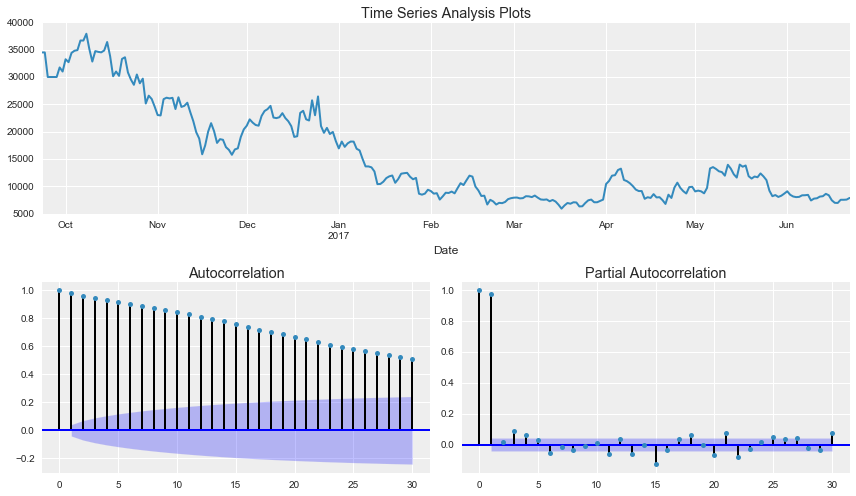

In [14]:
tsplot(player1_ts,lags = 30)

Исходный ряд не является стационарным (согласно визуальному анализу а также критерия Дики-Фуллера). Cезонность не просматривается.

### Проведем STL- декомпозицию

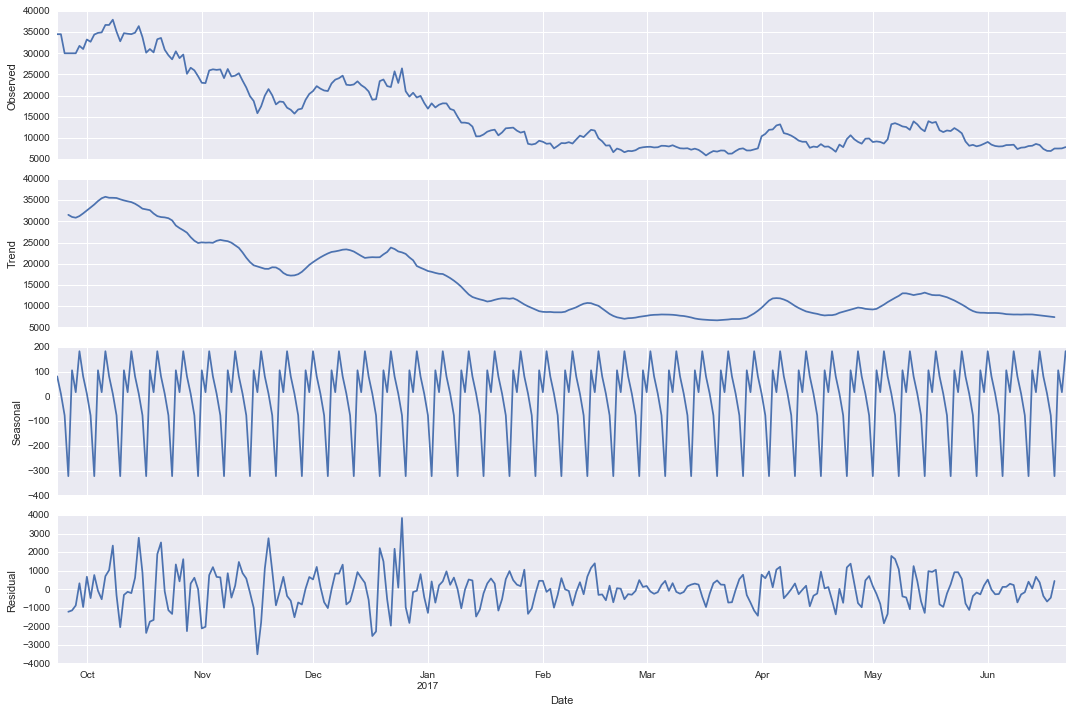

In [15]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(player1_ts).plot()
pylab.show()

Виден тренд. Сезонность несущественна.

### Проведем стабилизацию дисперсии

In [16]:
from scipy import stats

modified_ts, lmbda = stats.boxcox(player1_ts)


d:\winpython-64bit-3.5.2.3qt5\python-3.5.2.amd64\lib\site-packages\scipy\stats\morestats.py:905: RuntimeWarning: divide by zero encountered in log
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))
d:\winpython-64bit-3.5.2.3qt5\python-3.5.2.amd64\lib\site-packages\scipy\optimize\optimize.py:1877: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
d:\winpython-64bit-3.5.2.3qt5\python-3.5.2.amd64\lib\site-packages\scipy\optimize\optimize.py:1878: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
d:\winpython-64bit-3.5.2.3qt5\python-3.5.2.amd64\lib\site-packages\scipy\optimize\optimize.py:1876: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
d:\winpython-64bit-3.5.2.3qt5\python-3.5.2.amd64\lib\site-packages\scipy\optimize\optimize.py:1875: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)


In [17]:
lmbda

-4.927680762810154

-полученное значение слишком критичное. Попробуем обычное логарифмирование:


In [18]:
lmbda = 0
modified_ts = stats.boxcox(player1_ts,lmbda = 0)

Критерий Дики-Фуллера: p=0.448796
Ряд после преобразования Бокса-Кокса c пареметром lmbda: 0.000000


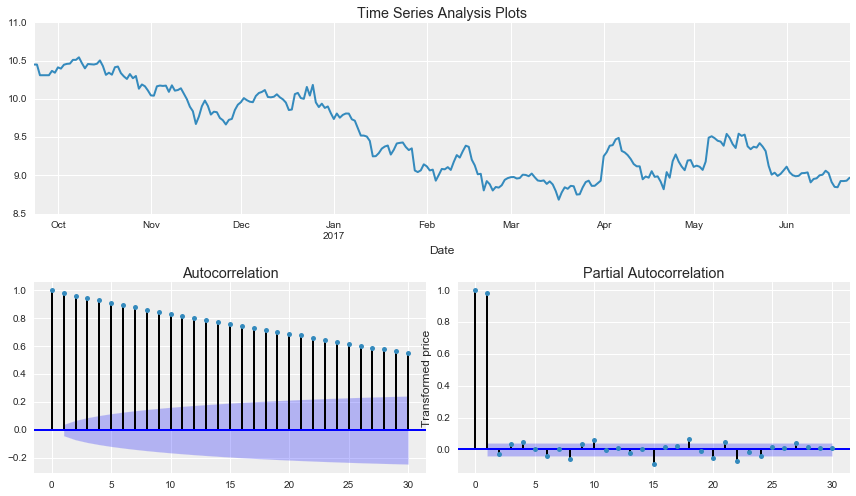

In [19]:
player1_ts_box=pd.Series(modified_ts)
player1_ts_box.index = player1_ts.index[:]

tsplot(player1_ts_box,lags = 30)
plt.ylabel(u'Transformed price')
print("Ряд после преобразования Бокса-Кокса c пареметром lmbda: %1f" % lmbda)
#plt.show()

Визуально ряд выглядит лучше.

### Избавляемся от тренда дифференцированием, произведем на полученом ряде STL-декомпозицию и построим графики автокорреляции

In [20]:
#дифференцируем и удаляем NAN (новый ряд стал на 1 короче)
#player1_ts_diff = player1_ts - player1_ts.shift(1)
player1_ts_diff = player1_ts_box - player1_ts_box.shift(1)
player1_ts_diff = player1_ts_diff[1:]

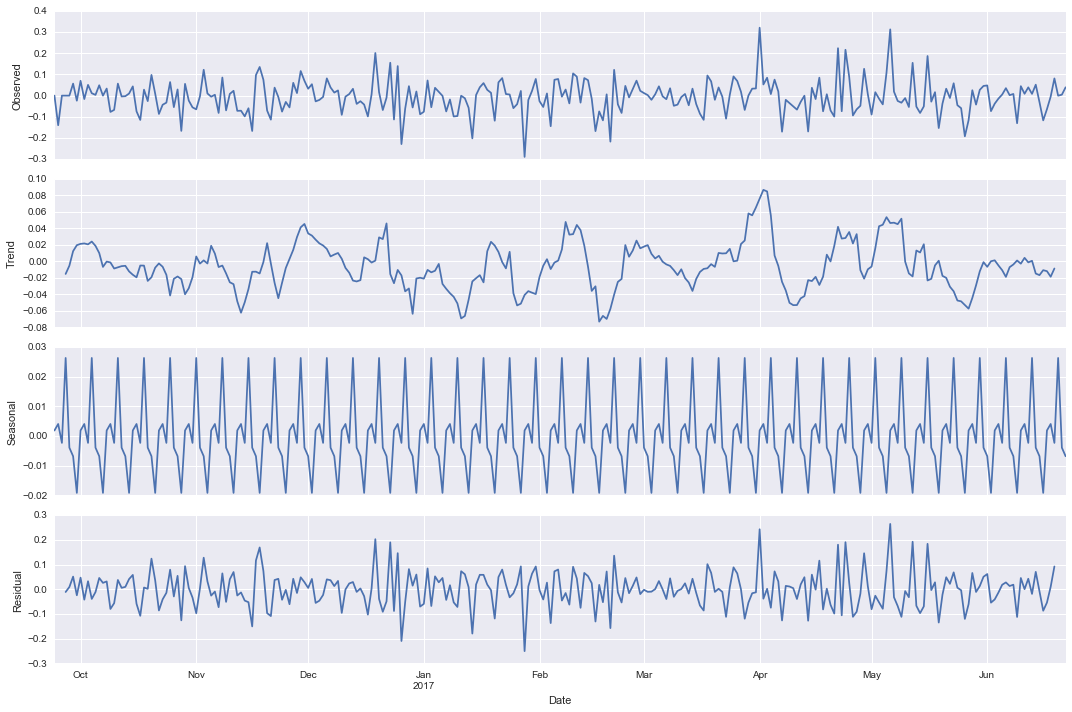

In [21]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(player1_ts_diff).plot()
pylab.show()

Критерий Дики-Фуллера: p=0.000000


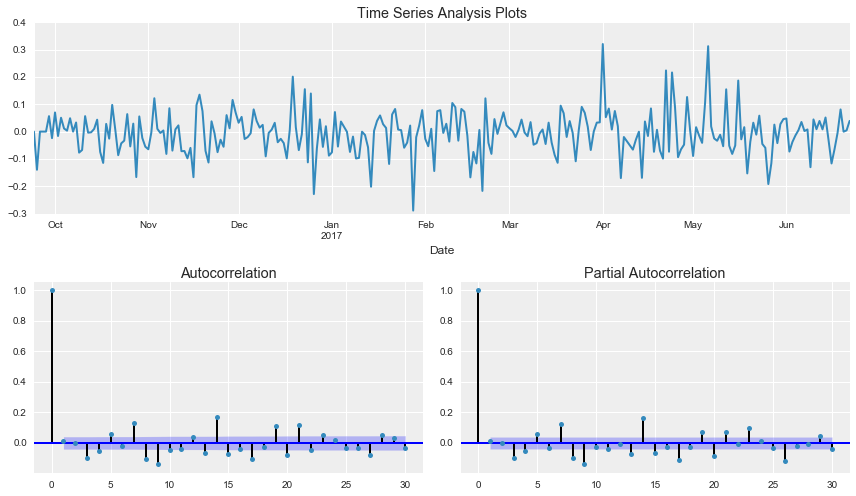

In [22]:
tsplot(player1_ts_diff,30)

Согласно критерия Дики-Фулера продифференцированый ряд можно считать стационарным

### Подбор параметров модели

In [23]:
D = 0 # нет сезонности
d = 1 # дифференцирование 1 порядка позволило сделать ряд стационарным

In [24]:
# Начальное значение для параметра Q даёт номер последнего сезонного лага, при котором автокорреляция значима.
# В нашем случае сезонных лагов нет
Q = 0

# Параметр q задаётся номером последнего несезонного лага, при котором автокорреляция значима.
# Руководствуемся также здравым смыслом.
q = 14

# P задаёт номер последнего сезонного лага, при котором частичная автокорреляция значима.
P = 0

# p задаётся как номер последнего несезонного лага, при котором частичная автокорреляция значима. 
# Руководствуемся также здравым смыслом.
p = 14



In [25]:
# Задаем диапазоны пареметров
ps = range(0, 15)
d = 1
qs = range(0, 15)
P = 0
Q = 0
D = 0


In [26]:
from itertools import product
parameters = product(ps, qs)
parameters_list = list(parameters)
print("Количество параметров: {}".format(len(parameters_list)))

Количество параметров: 225


In [27]:
import warnings

### Обучаем модель с подбором параметров

In [28]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(player1_ts_box, order=(param[0], d, param[1])).fit(disp=-1)
        
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')


wrong parameters: (0, 0)
wrong parameters: (2, 1)
wrong parameters: (2, 2)
wrong parameters: (3, 3)
wrong parameters: (4, 2)
wrong parameters: (4, 3)
wrong parameters: (4, 4)
wrong parameters: (4, 13)
wrong parameters: (4, 14)
wrong parameters: (5, 3)
wrong parameters: (5, 4)
wrong parameters: (5, 13)
wrong parameters: (5, 14)
wrong parameters: (6, 3)
wrong parameters: (6, 4)
wrong parameters: (6, 7)
wrong parameters: (6, 8)
wrong parameters: (6, 9)
wrong parameters: (6, 10)
wrong parameters: (6, 11)
wrong parameters: (6, 12)
wrong parameters: (6, 13)
wrong parameters: (6, 14)
wrong parameters: (7, 3)
wrong parameters: (7, 4)
wrong parameters: (7, 7)
wrong parameters: (7, 9)
wrong parameters: (7, 10)
wrong parameters: (7, 11)
wrong parameters: (7, 13)
wrong parameters: (8, 3)
wrong parameters: (8, 4)
wrong parameters: (8, 5)
wrong parameters: (8, 6)
wrong parameters: (8, 9)
wrong parameters: (8, 10)
wrong parameters: (8, 11)
wrong parameters: (8, 12)
wrong parameters: (8, 13)
wrong par

Лучший набор параметров:

In [29]:
best_param

(4, 9)

In [30]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

   parameters         aic
62     (4, 9) -607.807775
63    (4, 10) -605.867847
73     (5, 9) -605.423763
8      (0, 9) -604.759141
36     (2, 9) -604.676684


Лучшая модель:  

In [31]:
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  273
Model:               SARIMAX(4, 1, 9)   Log Likelihood                 317.904
Date:                Fri, 30 Jun 2017   AIC                           -607.808
Time:                        18:19:23   BIC                           -557.275
Sample:                    09-23-2016   HQIC                          -587.523
                         - 06-22-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5712      0.134     -4.259      0.000      -0.834      -0.308
ar.L2          0.4643      0.172      2.703      0.007       0.128       0.801
ar.L3         -0.3024      0.196     -1.544      0.1

### Анализ остатков
Проверяем на:
- несмещенность
- стационарность
- неавтокоррелированность

In [32]:
print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[1:], 0)[1])


Критерий Стьюдента: p=0.124214


согласно критерия стьюдента среднее остатков равно 0 - остатки несмещены

In [33]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[1:])[1])

Критерий Дики-Фуллера: p=0.000000


 -остатки стационарны.

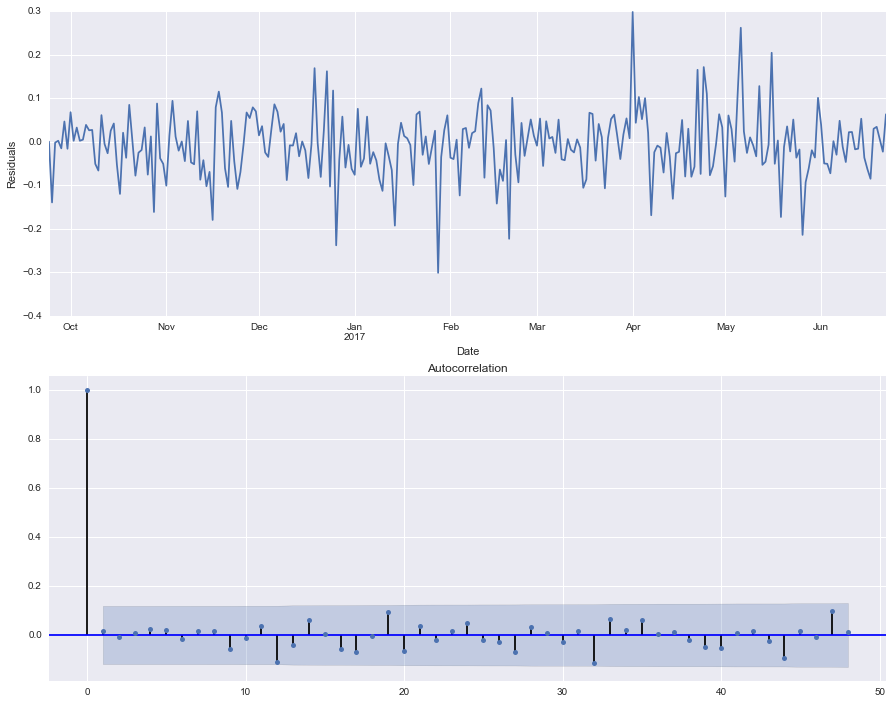

In [34]:
plt.figure(figsize(15,12))
plt.subplot(211)
best_model.resid[1:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[1:].values.squeeze(), lags=48, ax=ax)
plt.show()


Остатки не автокоррелированы

#### Посмотрим, насколько хорошо модель описывает данные:

In [35]:
# функция обратного преобразования Бокса-Кокса
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

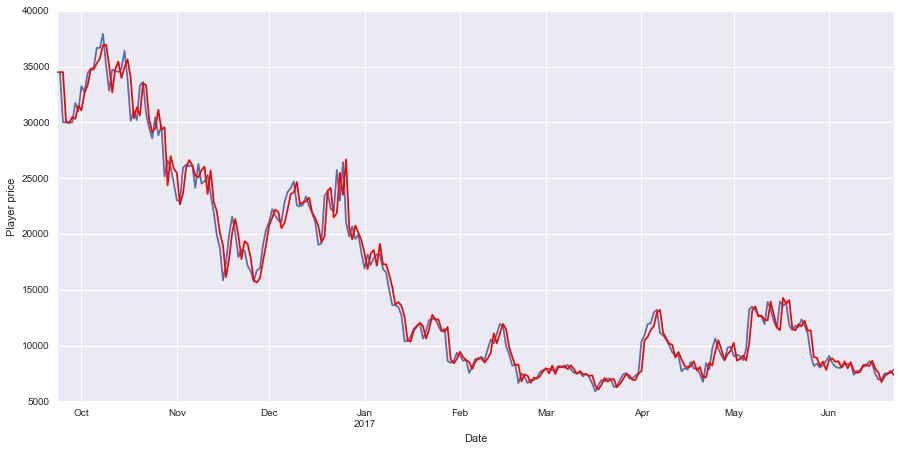

In [36]:
plt.figure(figsize(15,7))
player1_ts.plot()
#best_model.fittedvalues[1:].plot(color='r')
invboxcox(best_model.fittedvalues[1:], lmbda).plot(color = 'r')
plt.ylabel('Player price')
pylab.show()

** Посчитаем коэффициент детерминации **

In [37]:
from sklearn.metrics import r2_score

In [38]:
r2_score(invboxcox(best_model.fittedvalues[1:],lmbda), player1_ts[1:])

0.98078076213088239

## Прогноз

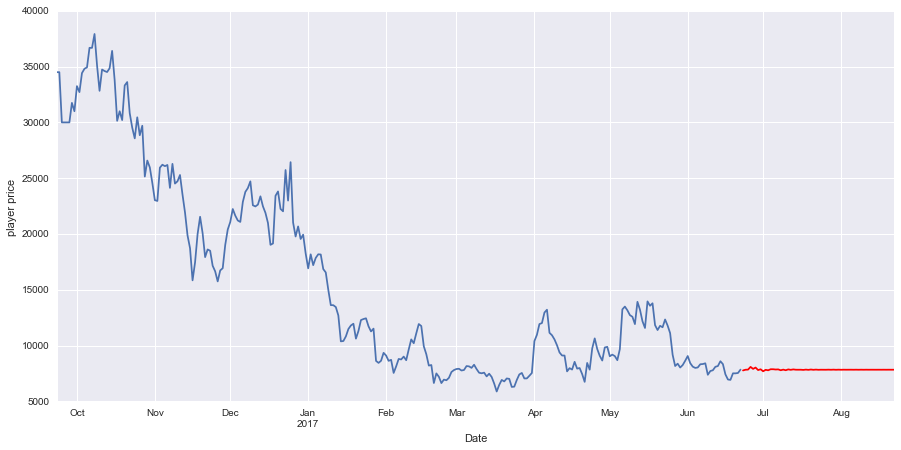

In [274]:
# Строим прогноз на 2 мес вперед
# Малополезный график в нашем случаее - просто интересно что там получится

plt.figure(figsize(15,7))
player1_ts.plot()
invboxcox(best_model.predict(start=273, end=333),lmbda).plot(color='r')
plt.ylabel('player price')
pylab.show()

## Тестируем прогнозирующую способность на 1 день вперед

Алгоритм:
 - отрезаем от выборки данные за последние 2 месяца
 - обучаем модель и делаем прогноз на один день вперед
 - сохраняем значение прогноза
 - расширяем ряд для обучения на 1 день (используя значения исходного ряда а не спрогнозированное значение)
 - повторяем с п. №2

In [94]:
class arima:
       
    def __init__(self, ps,d,qs):
        self.d = d
        parameters = product(ps, qs)
        self.parameters_list = list(parameters)
        print("Количество параметров: {}".format(len(self.parameters_list)))
        
    def fit(self, ts_data):
        self.results = []
        best_aic = float("inf")
        warnings.filterwarnings('ignore')

        for param in self.parameters_list:
            #print ("Tested parameters: ", param)
            
            #try except нужен, потому что на некоторых наборах параметров модель не обучается
            try:
                model = sm.tsa.statespace.SARIMAX(ts_data, order=(param[0], d, param[1])).fit(disp=-1)

            #выводим параметры, на которых модель не обучается и переходим к следующему набору
            except ValueError:
                #print('wrong parameters:', param)
                continue
            aic = model.aic
            #сохраняем лучшую модель, aic, параметры
            if aic < best_aic:
                self.best_model = model
                self.best_aic = aic
                self.best_param = param
            self.results.append([param, model.aic])
    
        warnings.filterwarnings('default')
        
        print("Best param: ", self.best_param)
        self.p = self.best_param[0]
        self.q = self.best_param[1]
        
        return self.best_model

In [61]:
ps = range(3, 8)
d = 1
qs = range(3, 10)


# серия для хранения результатов цен рассчитанных моделью
predicted_vals = pd.Series()

#инициализируем наш авторегрессор
regr = arima(ps, d, qs)


for i in reversed(range(1,30)):
    train = player1_ts_box[:-i]
    model = regr.fit(train)
    predicted = invboxcox(model.predict(model.nobs, model.nobs),lmbda)
    predicted_vals = pd.concat([predicted_vals, predicted])
    print("Predicted price: %1f, real price %1f" % (predicted, player1_ts[-i]))
    

Количество параметров: 35
Best param:  (7, 8)
Predicted price: 11905.131088, real price 11117.000000
Best param:  (7, 8)
Predicted price: 10688.918168, real price 9174.000000
Best param:  (7, 8)
Predicted price: 9429.969182, real price 8170.000000
Best param:  (7, 8)
Predicted price: 8633.311187, real price 8381.000000
Best param:  (7, 8)
Predicted price: 8213.888198, real price 8034.000000
Best param:  (7, 8)
Predicted price: 8357.322792, real price 8256.000000
Best param:  (7, 8)
Predicted price: 7797.738963, real price 8642.000000
Best param:  (7, 8)
Predicted price: 8548.877360, real price 9068.000000
Best param:  (7, 8)
Predicted price: 8620.951200, real price 8428.000000
Best param:  (7, 8)
Predicted price: 8621.798252, real price 8114.000000
Best param:  (7, 8)
Predicted price: 8470.003860, real price 8000.000000
Best param:  (7, 6)
Predicted price: 7883.108529, real price 8041.000000
Best param:  (7, 8)
Predicted price: 8321.568328, real price 8329.000000
Best param:  (7, 8)
Pr

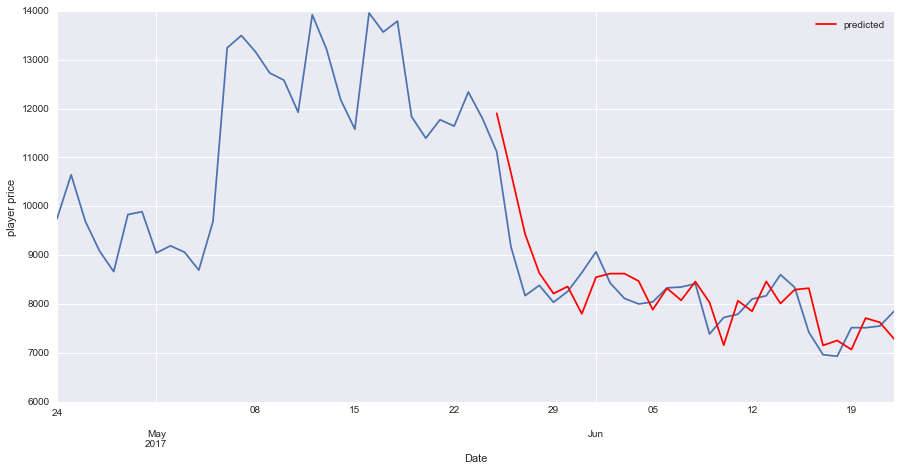

In [62]:
# Построим часть ряда за последних 2 месяца и прогноз за последних 30 дней.
plt.figure(figsize(15,7))
player1_ts[-60:].plot()
predicted_vals.plot(color='r', label  = 'predicted', legend = True)
plt.ylabel('player price')
pylab.show()

Видно, что модель плохо предсказывает резкие скачки цены.

**Строим график ошибок (остатков)**

In [69]:
errors = player1_ts[-29:] - predicted_vals

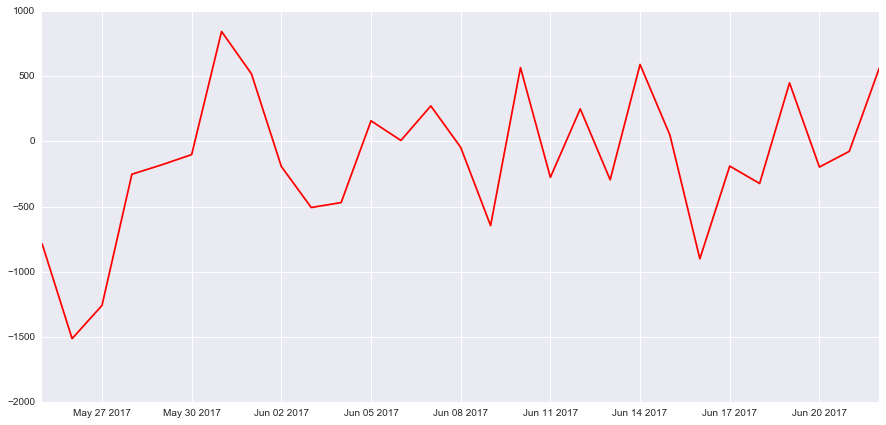

In [71]:
plt.plot(errors,color ='r')

In [72]:
#Средння ошибки. Также нужно бы проверить по Стьюденту на равность 0.
errors.mean()

-136.24218435090967

In [73]:
print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(errors, 0)[1])

Критерий Стьюдента: p=0.193777


Гипотеза о равности среднего значения остатков нулю не отклоняется.

In [75]:
# Коэффициент детерминации
r2_score(player1_ts[-29:], predicted_vals)


0.47154472928443303

In [77]:
# среднеквадратичная ошибка
from sklearn.metrics import mean_squared_error
mean_squared_error(player1_ts[-29:], predicted_vals)

311735.65234607831

In [78]:
# MAPE ошибка
def mape(y_true,y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape(player1_ts[-30:],predicted_vals)

5.218973029118942

## Тестируем прогнозирующую способность на 7 дней вперед
Алгоритм:
- отрезаем от выборки данные за последних 8 недель
- на полученном ряде обучаем модель и делаем прогноз на одну неделю вперед
- сохраняем значение прогноза
- расширяем ряд для обучения на 1 неделю (данными из оригинального ряда)
- повторяем с п. 2

In [96]:
ps = range(6, 11)
d = 1
qs = range(6, 11)

# серия для хранения результатов цен рассчитанных моделью
predicted_vals = pd.Series()

#инициализируем наш авторегрессор
regr = arima(ps,d,qs)

#Отматываем от ряда 8 недель и двигаемся шагами по 7 дней.

for i in reversed(range(7, 9*7, 7)):
    print("Подбираем параметры и строим прогноз неделю -%d" % (i/7))
    train = player1_ts_box[:-i]
    model = regr.fit(train)
    predicted = invboxcox(model.predict(model.nobs, model.nobs+6),lmbda)
    predicted_vals = pd.concat([predicted_vals, predicted])
  
    
    

Количество параметров: 25
Подбираем параметры и строим прогноз неделю -8
Best param:  (6, 10)
Подбираем параметры и строим прогноз неделю -7
Best param:  (7, 6)
Подбираем параметры и строим прогноз неделю -6
Best param:  (7, 6)
Подбираем параметры и строим прогноз неделю -5
Best param:  (8, 8)
Подбираем параметры и строим прогноз неделю -4
Best param:  (8, 8)
Подбираем параметры и строим прогноз неделю -3
Best param:  (7, 8)
Подбираем параметры и строим прогноз неделю -2
Best param:  (8, 7)
Подбираем параметры и строим прогноз неделю -1
Best param:  (8, 8)


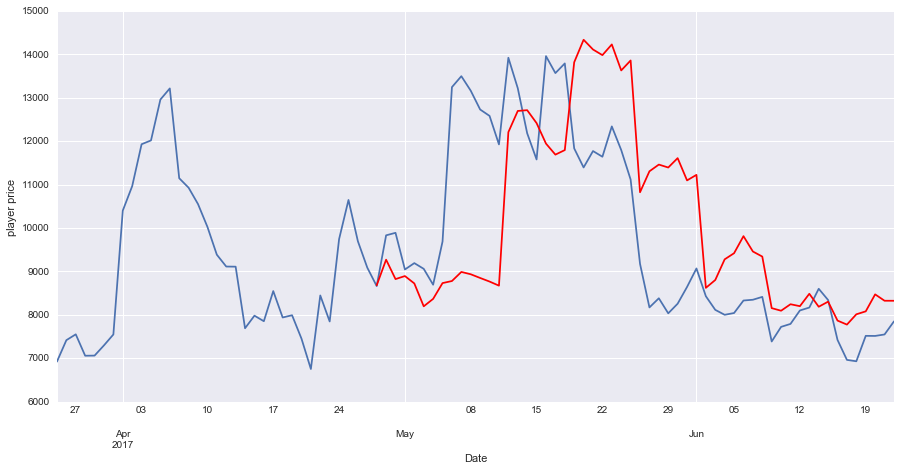

In [97]:
# Построим часть ряда за последние 3 мес и прогноз за последние 2 мес.
plt.figure(figsize(15,7))
player1_ts[-90:].plot()
predicted_vals.plot(color='r')
plt.ylabel('player price')
pylab.show()

Здесь также видно, что модель  не  предвидит резские скачки цен. Нужно добавлять регрессионную компоненту на каких-то внешних данных.

**Строим график ошибок (остатков)**

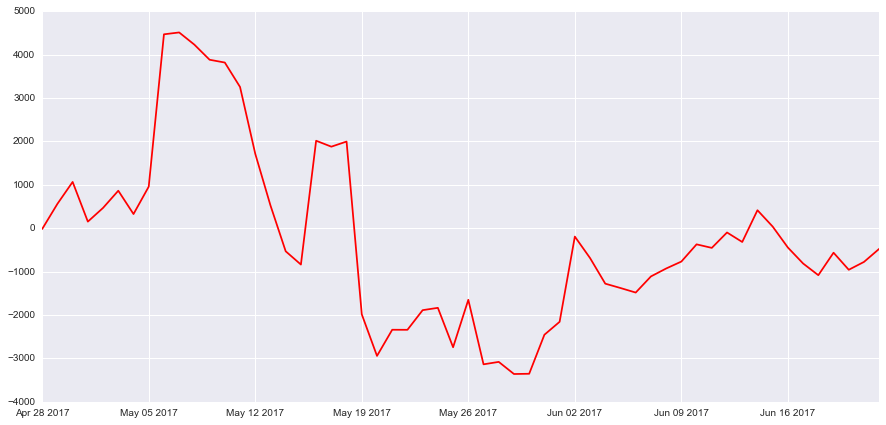

In [98]:
errors = player1_ts[-56:] - predicted_vals
plt.plot(errors,color ='r')

In [99]:
#Средняя ошибки. Также нужно бы проверить по Стьюденту на равность 0.
errors.mean()

-244.73302819426505

In [100]:
print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(errors, 0)[1])

Критерий Стьюдента: p=0.365144


Гипотеза о равности среднего значения остатков нулю не отклоняется.

In [101]:
# Коэффициент детерминации
r2_score(player1_ts[-56:], predicted_vals)

0.15930984164508266

In [102]:
# MAPE ошибка
mape(player1_ts[-56:],predicted_vals)

15.319765153194837

In [103]:
# посмотрим на полученный прогноз в числовой форме
for i in range(1,56):
    print("Date %s, True: %d, Predicted: %d" % (player1_ts.index[-56+i].strftime("%Y-%m-%d"), player1_ts[-56+i], predicted_vals[i]))

Date 2017-04-29, True: 9831, Predicted: 9269
Date 2017-04-30, True: 9889, Predicted: 8822
Date 2017-05-01, True: 9044, Predicted: 8892
Date 2017-05-02, True: 9191, Predicted: 8722
Date 2017-05-03, True: 9059, Predicted: 8195
Date 2017-05-04, True: 8693, Predicted: 8366
Date 2017-05-05, True: 9688, Predicted: 8730
Date 2017-05-06, True: 13246, Predicted: 8778
Date 2017-05-07, True: 13498, Predicted: 8987
Date 2017-05-08, True: 13163, Predicted: 8933
Date 2017-05-09, True: 12730, Predicted: 8848
Date 2017-05-10, True: 12583, Predicted: 8766
Date 2017-05-11, True: 11926, Predicted: 8671
Date 2017-05-12, True: 13923, Predicted: 12208
Date 2017-05-13, True: 13221, Predicted: 12696
Date 2017-05-14, True: 12183, Predicted: 12714
Date 2017-05-15, True: 11579, Predicted: 12416
Date 2017-05-16, True: 13960, Predicted: 11944
Date 2017-05-17, True: 13569, Predicted: 11690
Date 2017-05-18, True: 13792, Predicted: 11795
Date 2017-05-19, True: 11834, Predicted: 13818
Date 2017-05-20, True: 11395, Pre

### Посмотрим на корреляцию остатков с числом игроков в системе - может это та регрессионая компонента, которая поможет спасти ситуацию с плохим прогнозированием скачков цены?

In [104]:
# строим фичу "количество игроков в системе на определенную дату
no_players_added=stats_w_last_price.groupby('added_on')['player_id'].count()
no_of_players = no_players_added.cumsum()

# полученный ряд имеет много пропусков (дат в кроторые новые карточки игроков  не добавлялись). Нужно добавить все календарные 
# дни и заполнить их значениями из прошлых дней

# Задаем временной ряд
start_date = '2016-12-01'
end_date = '2017-06-22'
rng = pd.date_range(start_date, end_date)

no_of_players = no_of_players[rng].fillna(method='ffill')

In [88]:
#глянем что получилось
no_of_players[-56:]

2017-04-28    4201.0
2017-04-29    4209.0
2017-04-30    4209.0
2017-05-01    4209.0
2017-05-02    4209.0
2017-05-03    4227.0
2017-05-04    4228.0
2017-05-05    4228.0
2017-05-06    4233.0
2017-05-07    4233.0
2017-05-08    4233.0
2017-05-09    4233.0
2017-05-10    4272.0
2017-05-11    4272.0
2017-05-12    4293.0
2017-05-13    4296.0
2017-05-14    4296.0
2017-05-15    4298.0
2017-05-16    4300.0
2017-05-17    4338.0
2017-05-18    4338.0
2017-05-19    4338.0
2017-05-20    4342.0
2017-05-21    4342.0
2017-05-22    4342.0
2017-05-23    4369.0
2017-05-24    4386.0
2017-05-25    4387.0
2017-05-26    4408.0
2017-05-27    4411.0
2017-05-28    4411.0
2017-05-29    4411.0
2017-05-30    4425.0
2017-05-31    4443.0
2017-06-01    4443.0
2017-06-02    4466.0
2017-06-03    4466.0
2017-06-04    4466.0
2017-06-05    4466.0
2017-06-06    4491.0
2017-06-07    4498.0
2017-06-08    4520.0
2017-06-09    4520.0
2017-06-10    4520.0
2017-06-11    4521.0
2017-06-12    4521.0
2017-06-13    4562.0
2017-06-14   

In [105]:
#Корреляция Пирсона числа игроков в системе с абсолютным значением ошибки прогнозирования)
stats.pearsonr(no_of_players[-56:],  np.abs(errors))

(-0.36965967425204099, 0.005047994777395092)

**Yes! -  корреляция существенна. Мы спасены!, - есть надежда получить более точный прогноз**

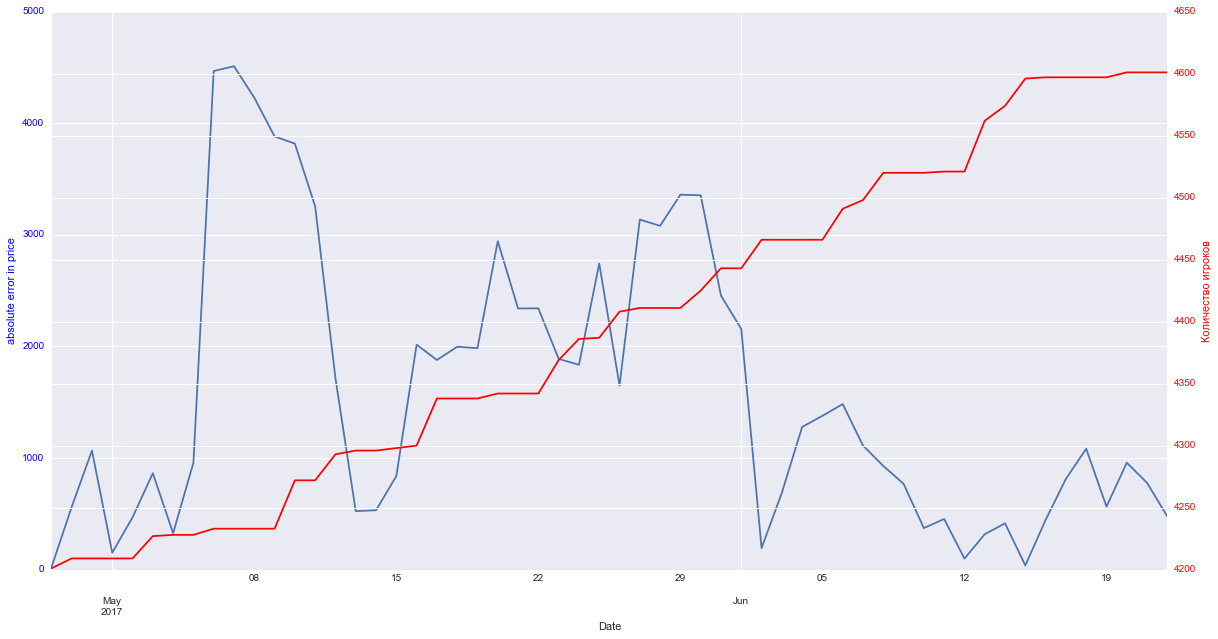

In [106]:
plt.figure(figsize(20,10))
fig, ax1 = plt.subplots()
ax1.set_ylabel('absolute error in price', color='b')
ax1.tick_params('y', colors='b')        
np.abs(errors).plot(x = rng, label = 'error in price', ax = ax1)


#график количества добавленых игроков
ax2 = ax1.twinx()
ax2.set_ylabel('Количество игроков', color='r')
ax2.tick_params('y', colors='r')

no_of_players[-56:].plot(color ='r', label = "количество игроков", ax = ax2)


Из графика видно, что ошибка прогнозирования существенна в те дни, когда росло количество игроков в системе. Но уровень ошибки неоднозначен. Нужно дальше изучать добавление каких именно игроков сильнее всего влияет на скачкообразное изменение цены, и ошибки ее прогнозирования.

## TODO:

- Сделать нормальную кросвалидацию, например, как тут:
https://habrahabr.ru/company/ods/blog/327242/#kross-validaciya-na-vremennyh-ryadah-podbor-parametrov

- Привести код к виду, удобному для серийного прогноза по множеству игроков
- Научится учитывать дополнительные регресионные компоненты (количество игроков в системе)